In [1]:
''' 1. 모듈 임포트 '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from torchvision import datasets, transforms

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.5.0+cu101  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. 개미와 벌 이미지 데이터 불러오기 및 전처리 '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("../data/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

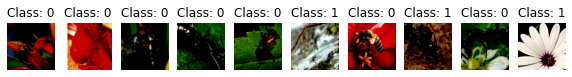

In [6]:
''' 4. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 5. 학습, Test 성능 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))


In [8]:
def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [9]:
''' 6. PyTorch 내에서 제공하는 딥러닝 모델 불러온 후 Output 크기 설정하기 '''
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [10]:
''' 7. Optimizer, Objective Function 설정하기 '''
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
''' 8. Resnet18 학습 실행 '''
''' 9. EPOCH 별 Test set Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/403 (0%)]	Train Loss: 0.692666
Train Epoch: 1 [160/403 (38%)]	Train Loss: 1.067360
Train Epoch: 1 [320/403 (77%)]	Train Loss: 0.559151

[EPOCH: 1], 	Validation Loss: 0.3091, 	Validation Accuracy: 61.04 % 

Train Epoch: 2 [0/403 (0%)]	Train Loss: 0.601038
Train Epoch: 2 [160/403 (38%)]	Train Loss: 0.628534
Train Epoch: 2 [320/403 (77%)]	Train Loss: 0.763903

[EPOCH: 2], 	Validation Loss: 0.0214, 	Validation Accuracy: 58.81 % 

Train Epoch: 3 [0/403 (0%)]	Train Loss: 0.707605
Train Epoch: 3 [160/403 (38%)]	Train Loss: 0.753498
Train Epoch: 3 [320/403 (77%)]	Train Loss: 0.699602

[EPOCH: 3], 	Validation Loss: 0.0221, 	Validation Accuracy: 61.04 % 

Train Epoch: 4 [0/403 (0%)]	Train Loss: 0.657449
Train Epoch: 4 [160/403 (38%)]	Train Loss: 0.576715
Train Epoch: 4 [320/403 (77%)]	Train Loss: 0.717352

[EPOCH: 4], 	Validation Loss: 0.0223, 	Validation Accuracy: 61.79 % 

Train Epoch: 5 [0/403 (0%)]	Train Loss: 0.727323
Train Epoch: 5 [160/403 (38%)]	Train Loss: 0.684300
Tra

In [12]:
''' 10. IMAGENET 데이터로 학습이 된 ResNet18 모델을 불러온 후 Fine Tuning 해보기 '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/403 (0%)]	Train Loss: 1.000484
Train Epoch: 1 [160/403 (38%)]	Train Loss: 0.808243
Train Epoch: 1 [320/403 (77%)]	Train Loss: 0.784988

[EPOCH: 1], 	Validation Loss: 0.0189, 	Validation Accuracy: 68.98 % 

Train Epoch: 2 [0/403 (0%)]	Train Loss: 0.622819
Train Epoch: 2 [160/403 (38%)]	Train Loss: 0.459818
Train Epoch: 2 [320/403 (77%)]	Train Loss: 0.541958

[EPOCH: 2], 	Validation Loss: 0.0181, 	Validation Accuracy: 72.70 % 

Train Epoch: 3 [0/403 (0%)]	Train Loss: 0.465533
Train Epoch: 3 [160/403 (38%)]	Train Loss: 0.679961
Train Epoch: 3 [320/403 (77%)]	Train Loss: 0.660873

[EPOCH: 3], 	Validation Loss: 0.0162, 	Validation Accuracy: 71.22 % 

Train Epoch: 4 [0/403 (0%)]	Train Loss: 0.329428
Train Epoch: 4 [160/403 (38%)]	Train Loss: 0.448955
Train Epoch: 4 [320/403 (77%)]	Train Loss: 0.362659

[EPOCH: 4], 	Validation Loss: 0.0116, 	Validation Accuracy: 87.59 % 

Train Epoch: 5 [0/403 (0%)]	Train Loss: 0.272688
Train Epoch: 5 [160/403 (38%)]	Train Loss: 0.408324
Tra